# Ligand-Receptor Inference

As a result of the growing interest in cell-cell communication (CCC) inference, a number of computational tools in single-cell transcriptomics have emerged. Although, there many different categories and approaches to infer CCC events, in this tutorial we will focus on those that infer interactions between ligands and receptions, commonly referred to as ligand-receptor inference methods (e.g. ([Efremova et al., 2020](https://www.nature.com/articles/s41596-020-0292-x), [Hou et al., 2020](https://www.nature.com/articles/s41467-020-18873-z), [Jin et al., 2021](https://www.nature.com/articles/s41467-021-21246-9), [Raredon et al., 2022](https://www.nature.com/articles/s41598-022-07959-x)). These tools typically rely gene expression information as a proxy of protein abundance, and work downstream of pre-processing of the data, and the acquisition of biologically-meaningful cell groups. These CCC tools infer intercellular interactions in a hypothesis-free manner, meaning that they infer all possible interactions between cell clusters, relying on prior knowledge of the potential interactions. Here, one group of cells is considered the source of the communication signal and the other is the receiver of the signal. CCC events are thus represented as interactions between proteins, expressed by any combination of source and receiver cell clusters.

The information about the interacting proteins is commonly extracted from prior knowledge resources. In the case of ligand-receptor methods, the interactions can also be represented by heteromeric protein complexes ([Efremova et al., 2020](https://www.nature.com/articles/s41596-020-0292-x), [Jin et al., 2021](https://www.nature.com/articles/s41467-021-21246-9), [Noël et al., 2021](https://www.nature.com/articles/s41467-021-21244-x)). 

Here, we will use liana to obtain a consensus score for each ligand-receptor interaction inferred by the different tools, implemented in LIANA. Further, we will make use of LIANA's consensus resource which combines a number of expert-curated ligand-receptor resources.


## Environment Setup

In [1]:
import os
import numpy as np
import pandas as pd

import scanpy as sc
import cell2cell as c2c

import liana as li
import plotnine as p9

from tqdm.auto import tqdm

## Directories

In [2]:
output_folder = '../Data/LIANA-outputs/'
c2c.io.directories.create_directory(output_folder)

../Data/LIANA-outputs/ already exists.


## Data

In [3]:
adata = c2c.datasets.balf_covid()

In [4]:
adata

AnnData object with n_obs × n_vars = 63103 × 33538
    obs: 'sample', 'sample_new', 'group', 'disease', 'hasnCoV', 'cluster', 'celltype', 'condition'

In [5]:
adata.obs.head()

,sample,sample_new,group,disease,hasnCoV,cluster,celltype,condition
AAACCCACAGCTACAT_3,C100,HC3,HC,N,N,27.0,B,Control
AAACCCATCCACGGGT_3,C100,HC3,HC,N,N,23.0,Macrophages,Control
AAACCCATCCCATTCG_3,C100,HC3,HC,N,N,6.0,T,Control
AAACGAACAAACAGGC_3,C100,HC3,HC,N,N,10.0,Macrophages,Control
AAACGAAGTCGCACAC_3,C100,HC3,HC,N,N,10.0,Macrophages,Control


## Short preprocessing (to 01?)

^ Maybe best to move this part to the 01 notebook, here we just load the proccessed adata object and plot the UMAP just as a reminder of the clusters.

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [7]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

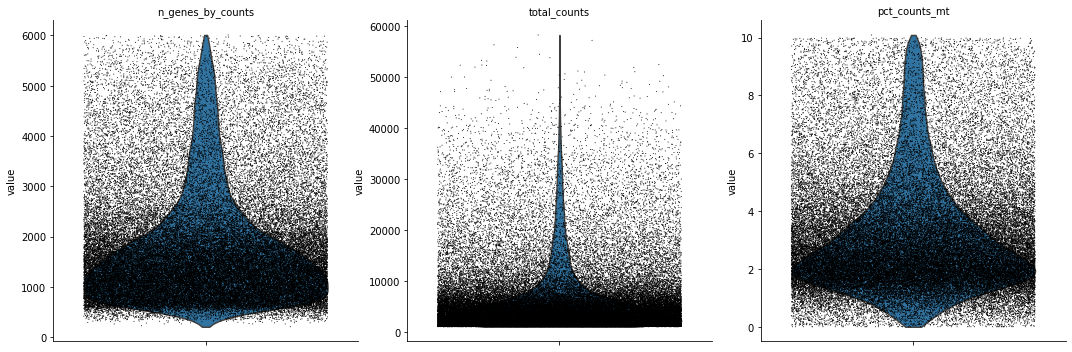

In [8]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

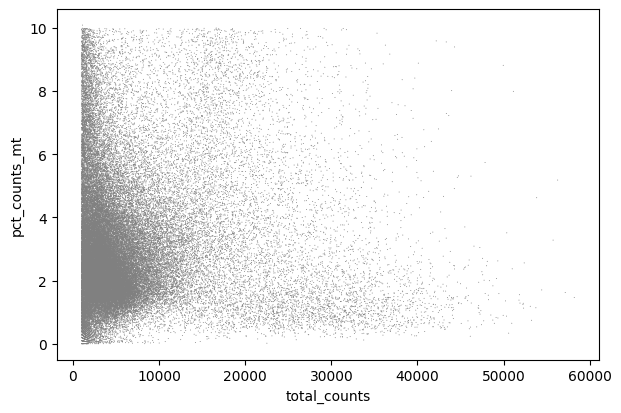

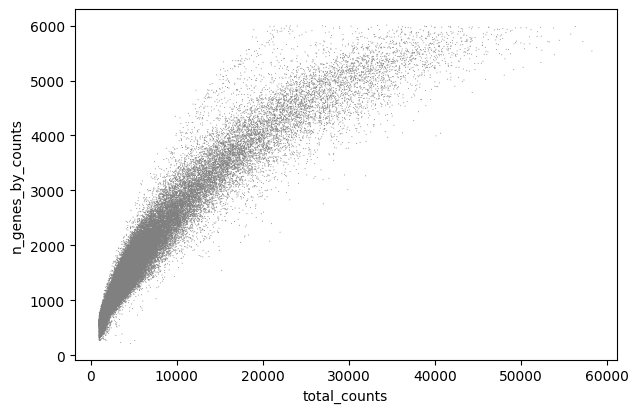

In [9]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [10]:
adata = adata[adata.obs.n_genes_by_counts < 5500, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

In [11]:
adata

View of AnnData object with n_obs × n_vars = 62552 × 24798
    obs: 'sample', 'sample_new', 'group', 'disease', 'hasnCoV', 'cluster', 'celltype', 'condition', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [12]:
sc.pp.normalize_total(adata, target_sum=1e6)

/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.


In [13]:
sc.pp.log1p(adata)

In [14]:
adata.raw = adata.copy()

## Predicting CCC events with LIANA

Now that we have the preprocessed data loaded, we will use liana to score the interactions inferred by the different tools.

`liana` is highly modularized and it implements a number of methods to score ligand-receptor interactions, we can list those with the following command: 


In [15]:
li.method.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


Here we see that liana classifies interaction scores into two categories: those that infer the **Magnitude** and **Specificity** of interactions. The **Magnitude** of an interactions is a measure of the strength of the interaction's expression, and the **Specificity** of an interaction is a measure of how specific is an interaction to a given pair of clusters. Generally, these categories are complementary, and the magnitude of the interaction is a proxy of the specificity of the interaction. For example, a ligand-receptor interaction with a high magnitude score is likely to be specific, and vice versa. 

## Scoring Functions

We will now describe the mathematical formulation of the magnitude and specificity scores we will use in this tutorial:

### Shared Notations


`k` is the k-th ligand-receptor interaction 

`L` - expression of ligand L

`R` - expression of receptor R

`C` - cell cluster

`i` - cell group i

`j` - cell group j

`M` - the library-size normalized and log1p-transformed gene expression matrix

`X` - normalized gene expression vector

### CellPhoneDBv2
**Magnitude**: 
![lr_means](../../Figures/scoring_functions/lr_mean.svg)

**Specificity**: CellPhoneDBv2 introduced a **permutation approach** also adapted by other methods, see permutation formulation below.



### Geometric Mean
**Magnitude**:
![lr_means](../../Figures/scoring_functions/lr_gmean.svg);

where GeometricMean is calculated as follows:

![geometric_mean](../../Figures/scoring_functions/geometric_mean.svg)


**Specificity**:
An adaptation of CellPhoneDBv2's permutation approach.

### CellChat

**Magnitude**:
![lr_prob](../../Figures/scoring_functions/lr_prob.svg)

where `TriMean` represents Tuckey's Trimean function:

![trimean](../../Figures/scoring_functions/trimean.svg)

Note that the original CellChat implementation also uses information of mediator proteins, which is specific to the CellChat resource.
Since we are using the consensus resource, we will not use this information, and hence the implementation of CellChat's `LR_probability` in LIANA is simplified to be resource-agnostic.

**Specificity**:
An adaptation of CellPhoneDBv2's permutation approach.

The specificity scores of these three method is calculated as follows:

![lr_permutation](../../Figures/scoring_functions/lr_permutation.svg)

where `P` is the number of permutations, and `L*` and `R*` are ligand and receptor expression summarized according by each method, i.e. `arithmetic mean` for CellPhoneDB, `TriMean` for CellChat, and `geometric mean` for Geometric Mean.

### SingleCellSignalR

**Magnitude**:
![lrscore](../../Figures/scoring_functions/lr_score.svg)

where `mu` is the mean of the expression matrix `M`

### NATMI

**Magnitude**:
![lr_product](../../Figures/scoring_functions/lr_product.svg)

**Specificity**:
![specificity_weight](../../Figures/scoring_functions/specificity_weight.svg)

### Connectome

**Magnitude**:
![lr_product](../../Figures/scoring_functions/lr_product.svg)

**Specificity**:
![zmean](../../Figures/scoring_functions/zmean.svg)

where `z` is the z-score of the expression matrix `M`:

![zscore](../../Figures/scoring_functions/zscore.svg)

### log2FC

**Specificity**:
![log2fc](../../Figures/scoring_functions/lr_log2fc.svg)

where log2FC for each gene is calculated as:

![log2fc](../../Figures/scoring_functions/log2fc.svg)


What the above equations show is that there are many commonalities between the different methods, yet there are also many variations in the way the magnitude and specificity scores are calculated. 

### Score Distributions

In [48]:
# pick a sample to infer the communication scores for
sadata = adata[adata.obs['sample']=='C100']

Let's Run LIANA's Aggregate for a single sample, this does not return only the a consensus rank distribution, but also the scores for each method that is included in liana's `rank_aggregate`

The parameters that we will use are the following:
- `groupby` is the column in the `meta` dataframe that contains the cell groups
- `use_raw` is a boolean that indicates whether to use the `.raw` attribute of the `adata` object, or the `.X` attribute
- `expr_prop` is the proportion of cells that need to express a ligand-receptor pair for it to be considered as a ligand-receptor pair
- `verbose` is a boolean that indicates whether to print the progress of the function

(Other parameters are described in the documentation of the function, as well as in more detail below)

In [54]:
%%time
li.method.rank_aggregate(sadata, groupby='celltype', use_raw=False, expr_prop=0.1, verbose=True)

Using `.X`!
5580 features of mat are empty, they will be removed.


/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/pandas/core/indexing.py:1625: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


The following cell identities were excluded: Plasma
0.33 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 2548 samples and 19218 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:05<00:00, 192.95it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [00:45<00:00, 22.08it/s]


CPU times: user 1min 6s, sys: 518 ms, total: 1min 7s
Wall time: 1min 6s


LIANA's results are by default save to the `liana_res` slot in `adata.uns`

In [50]:
liana_res = sadata.uns['liana_res'].copy()
# only keep those that are not liana's ranks
liana_res = liana_res.loc[:, liana_res.columns[~liana_res.columns.str.contains(pat = 'rank')]]
liana_res.head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals
5756,T,NK,B2M,KLRC1,7.873278,0.0,57.891018,1.679697,2.348660,0.085614,0.910135,0.454482,0.0
6624,NK,T,B2M,CD3D,7.885819,0.0,58.238614,1.135650,2.577814,0.061187,0.910380,0.449616,0.0
5665,NK,NK,B2M,KLRC1,7.860856,0.0,57.745709,1.658719,2.296556,0.085399,0.910032,0.454804,0.0
6733,T,T,B2M,CD3D,7.898241,0.0,58.385164,1.156628,2.629918,0.061341,0.910482,0.449295,0.0
5731,T,NK,B2M,KLRD1,7.843443,0.0,57.300439,1.907270,2.701107,0.095502,0.909715,0.451106,0.0


Here, we can see all of the different scores for each method, as well as the consensus scores for `magnitude` and `specificity`.

To provide a better illustration of the different scores, we will now plot the distribution of scores for each of the methods.

In [51]:
# convert to long format by index, and each score and value in different columns
liana_res = liana_res.melt(id_vars=['source', 'target', 'ligand_complex', 'receptor_complex'], var_name='score', value_name='value')

/home/dbdimitrov/.local/lib/python3.8/site-packages/plotnine/facets/facet.py:440: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/home/dbdimitrov/.local/lib/python3.8/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


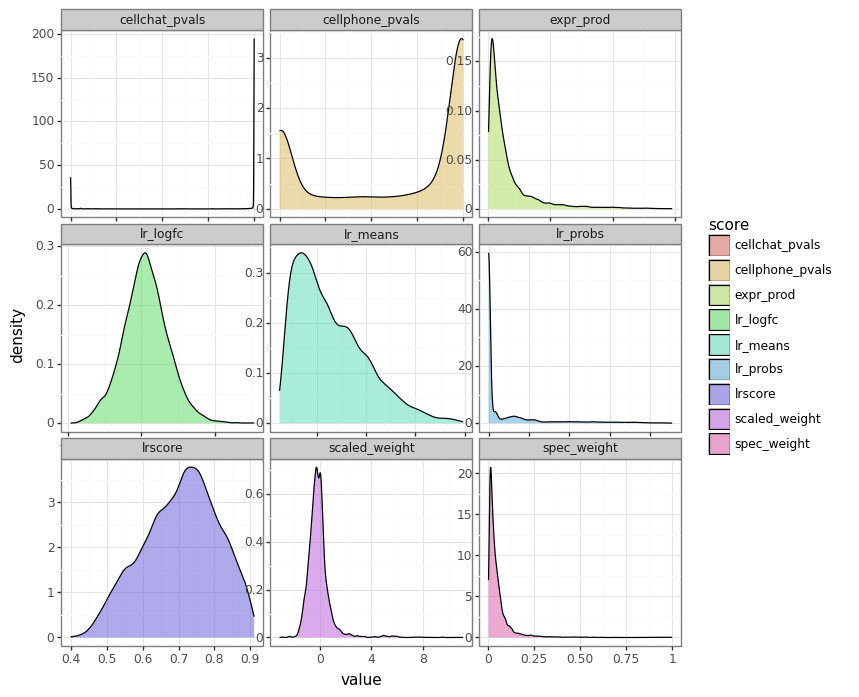

<ggplot: (8794850354661)>

In [52]:
(p9.ggplot(liana_res, p9.aes(x='value', fill='score')) + 
 p9.geom_density(alpha=0.5) + 
 p9.facet_wrap('~score', scales='free') +
 p9.theme_bw() +
 p9.theme(figure_size=(8, 8)))

This show how different each of the scoring functions are from each other. Unsurprisingly, independent evaluations have shown that the choice of method and/or resource leads to limited consensus in inferred predictions when using different tools ([Dimitrov et al., 2022](https://www.nature.com/articles/s41467-022-30755-0), [Liu et al., 2022](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-022-02783-y), [Wang et al., 2022](https://academic.oup.com/bfg/article/21/5/339/6640320)). To this end, we have implemented a consensus score that is a rank aggregate of the scores obtained by the different methods, and for the sake of these tutorials we will use this consensus score to rank the interactions, specifically the one that aggregates the magnitude scores from different functions.


### LIANA's Rank Aggregate

LIANA calculates an aggregate rank for both magnitude and specificity as defined above. The `rank_aggregate` function of liana uses a re-implementation of the RobustRankAggregate method by [Kolde et al., 2012](https://pubmed.ncbi.nlm.nih.gov/22247279/), and generates a probability distribution for ligand-receptors that are ranked consistently better than expected under null hypothesis. It thus provides a measure of the confidence of the rank of the ligand-receptor interactions across methods, that can also be treated as a p-value.

FORMULA GOES HERE

### Single-Sample Dotplot

Now that we are familiar with the what LIANA's aggregate scores are, let's generate a basic dotplot with the most highly-ranked ligand-receptor interactions for this sample.

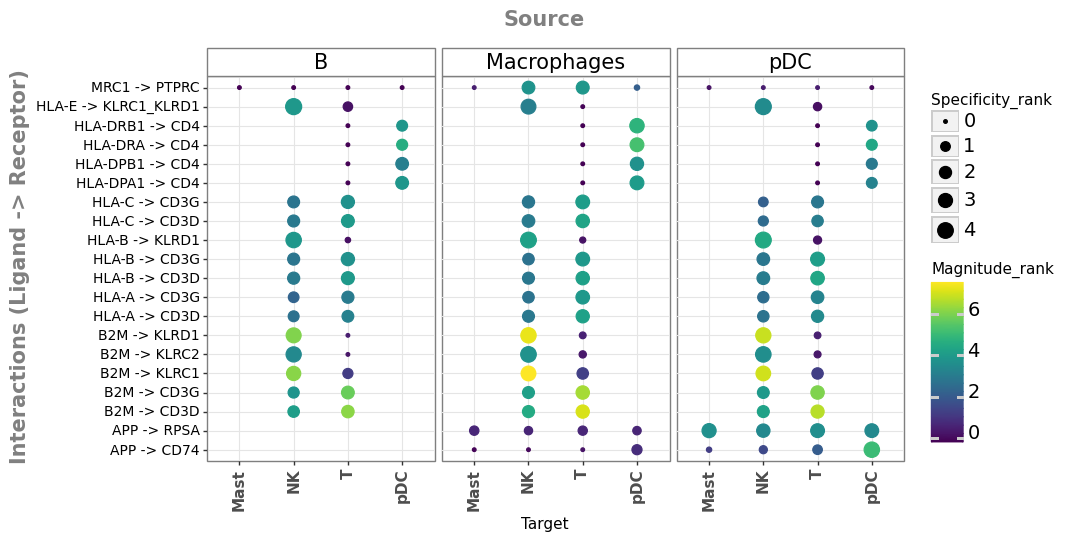

<ggplot: (8794851388594)>

In [66]:
li.pl.dotplot(
    adata=sadata,
    colour="magnitude_rank",
    size="specificity_rank",
    inverse_colour=True,  # we inverse sign since we want small p-values to have large sizes
    inverse_size=True,
    # We choose only the cell types which we wish to plot
    source_labels=["B", "pDC", "Macrophages"],
    target_labels=["T", "Mast", "pDC", "NK"],
    # since the rank_aggregate can also be interpreted as a probability distribution
    # we can again filter them according to their specificity significance
    # yet here the interactions are filtered according to
    # how consistently highly-ranked is their specificity across the methods
    filterby="specificity_rank",
    filter_lambda=lambda x: x <= 0.05,
    # again, we can also further order according to magnitude
    orderby="magnitude_rank",
    orderby_ascending=True,  # prioritize those with lowest values
    top_n=20,  # and we want to keep only the top 20 interactions
    figure_size=(9, 5),
    size_range=(1, 6),
)

Great! We have now obtained ligand-receptor predictions for a single sample. What we see here is that interactions are predicted across cell types and are typically specific to pairs of cell types.

Note that missing dots here would represent interactions for which the ligand and receptor are not expressed above the `expr_prop`.

## Run LIANA by Sample

Now that we have familiarized ourselves with how ligand-receptor methods in LIANA work and how the results look by sample, let's run LIANA's `rank_aggregate` on all of the samples in the dataset. These results will be used to generate a tensor of ligand-receptor interactions across contexts that will be decomposed into CCC patterns by `Tensor-Cell2cell`.

This is easily done with liana with the internal to the method instances function called `by_sample`. So, we will use the same parameters as before, but we will also add the `by_sample` parameter, which is a string that indicates the column in the `adata.obs` dataframe.

In [55]:
%%time
li.mt.rank_aggregate.by_sample(adata, sample_key='sample_new', groupby='celltype', expr_prop=0.1, verbose=True)
# I will implement the CellChat perms in numba and allow a more minimal verbose option to show progress

Now running HC1
Using `.raw`!
5703 features of mat are empty, they will be removed.


/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/pandas/core/indexing.py:1625: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


The following cell identities were excluded: Plasma, pDC
0.33 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 8450 samples and 19095 features
Assuming that counts were `natural` log-normalized!


  0%|          | 0/1000 [00:00<?, ?it/s]

Running CellPhoneDB


100%|██████████| 1000/1000 [00:07<00:00, 129.42it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


  0%|          | 0/1000 [00:00<?, ?it/s]

Running CellChat


100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]


Now running HC2
Using `.raw`!
6725 features of mat are empty, they will be removed.


/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/pandas/core/indexing.py:1625: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


The following cell identities were excluded: NK, pDC
0.38 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 8149 samples and 18073 features
Assuming that counts were `natural` log-normalized!


  2%|▏         | 18/1000 [00:00<00:05, 179.12it/s]

Running CellPhoneDB


100%|██████████| 1000/1000 [00:05<00:00, 183.72it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


  0%|          | 0/1000 [00:00<?, ?it/s]

Running CellChat


100%|██████████| 1000/1000 [02:00<00:00,  8.32it/s]


Now running HC3
Using `.raw`!
5580 features of mat are empty, they will be removed.


/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/pandas/core/indexing.py:1625: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


The following cell identities were excluded: Plasma
0.33 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 2548 samples and 19218 features
Assuming that counts were `natural` log-normalized!


  0%|          | 0/1000 [00:00<?, ?it/s]

Running CellPhoneDB


100%|██████████| 1000/1000 [00:04<00:00, 214.86it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [00:39<00:00, 25.33it/s]


Now running M1
Using `.raw`!
3113 features of mat are empty, they will be removed.


/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/pandas/core/indexing.py:1625: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


The following cell identities were excluded: Mast, Neutrophil
0.22 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 3376 samples and 21685 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:06<00:00, 165.60it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [00:43<00:00, 23.00it/s]


Now running M2
Using `.raw`!
3340 features of mat are empty, they will be removed.


/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/pandas/core/indexing.py:1625: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


The following cell identities were excluded: Mast, Neutrophil, Plasma
0.21 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 3174 samples and 21458 features
Assuming that counts were `natural` log-normalized!


  0%|          | 0/1000 [00:00<?, ?it/s]

Running CellPhoneDB


100%|██████████| 1000/1000 [00:05<00:00, 191.70it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [00:51<00:00, 19.46it/s]


Now running M3
Using `.raw`!
8265 features of mat are empty, they will be removed.
The following cell identities were excluded: Mast, Neutrophil, Plasma, pDC


/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/pandas/core/indexing.py:1625: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.39 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 348 samples and 16533 features
Assuming that counts were `natural` log-normalized!


  0%|          | 0/1000 [00:00<?, ?it/s]

Running CellPhoneDB


100%|██████████| 1000/1000 [00:02<00:00, 475.85it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


  0%|          | 0/1000 [00:00<?, ?it/s]

Running CellChat


100%|██████████| 1000/1000 [00:05<00:00, 198.95it/s]


Now running S1
Using `.raw`!
2524 features of mat are empty, they will be removed.


/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/pandas/core/indexing.py:1625: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.20 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 11758 samples and 22274 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:11<00:00, 89.31it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [02:47<00:00,  5.97it/s]


Now running S2
Using `.raw`!
1629 features of mat are empty, they will be removed.


/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/pandas/core/indexing.py:1625: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.15 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 16854 samples and 23169 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:17<00:00, 56.88it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [04:48<00:00,  3.47it/s]


Now running S3
Using `.raw`!
4570 features of mat are empty, they will be removed.
The following cell identities were excluded: B, Plasma


/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/pandas/core/indexing.py:1625: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.28 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 1283 samples and 20228 features
Assuming that counts were `natural` log-normalized!


  0%|          | 0/1000 [00:00<?, ?it/s]

Running CellPhoneDB


100%|██████████| 1000/1000 [00:02<00:00, 354.08it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


  0%|          | 0/1000 [00:00<?, ?it/s]

Running CellChat


100%|██████████| 1000/1000 [00:16<00:00, 59.96it/s]


Now running S4
Using `.raw`!
3769 features of mat are empty, they will be removed.
The following cell identities were excluded: B, pDC


/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/pandas/core/indexing.py:1625: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.21 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 1641 samples and 21029 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:04<00:00, 245.66it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [00:24<00:00, 40.63it/s]


Now running S5
Using `.raw`!
4236 features of mat are empty, they will be removed.
The following cell identities were excluded: Plasma


/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/pandas/core/indexing.py:1625: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.24 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 2046 samples and 20562 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:03<00:00, 270.67it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [00:25<00:00, 39.15it/s]


Now running S6
Using `.raw`!
3430 features of mat are empty, they will be removed.
The following cell identities were excluded: Mast, pDC


/home/dbdimitrov/anaconda3/envs/cell2cell/lib/python3.8/site-packages/pandas/core/indexing.py:1625: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.23 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 2879 samples and 21368 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:05<00:00, 189.74it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [00:43<00:00, 23.06it/s]


CPU times: user 19min 7s, sys: 2min 19s, total: 21min 26s
Wall time: 21min 38s


Here, we can see that the results look very similar as before with the exception that we have an additional column for the sample name, and the results are now by sample.

### Check the results

In [57]:
adata.uns['liana_res'].head()

,sample_new,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,steady_rank,specificity_rank,magnitude_rank
0,HC1,T,NK,B2M,CD3D,7.065181,0.002,41.876954,0.782763,1.938351,0.071258,0.934876,0.389954,0.003,0.003978,0.011225,2.653267e-08
1,HC1,Macrophages,NK,B2M,CD3D,7.065099,0.002,41.876264,0.782480,2.064648,0.071257,0.934876,0.390164,0.003,0.003997,0.011270,4.584030e-08
2,HC1,NK,NK,B2M,CD3D,6.917353,0.004,40.626418,0.271133,1.779140,0.069130,0.933947,0.386687,0.004,0.005647,0.015032,1.546285e-07
3,HC1,B,NK,B2M,CD3D,6.886024,0.004,40.361391,0.162700,1.689197,0.068679,0.933745,0.381069,0.004,0.006097,0.016024,5.690368e-07
4,HC1,T,NK,B2M,KLRD1,6.943012,0.000,39.457856,5.423936,3.865772,0.166753,0.933042,0.386556,0.000,0.000002,0.000016,7.151086e-07


We can also generate a dotplot for the most highly-ranked ligand-receptor interactions for each sample.
Let's pick the first two distinct interaction in the list, and see how they look like in the `dotplot_by_sample`.

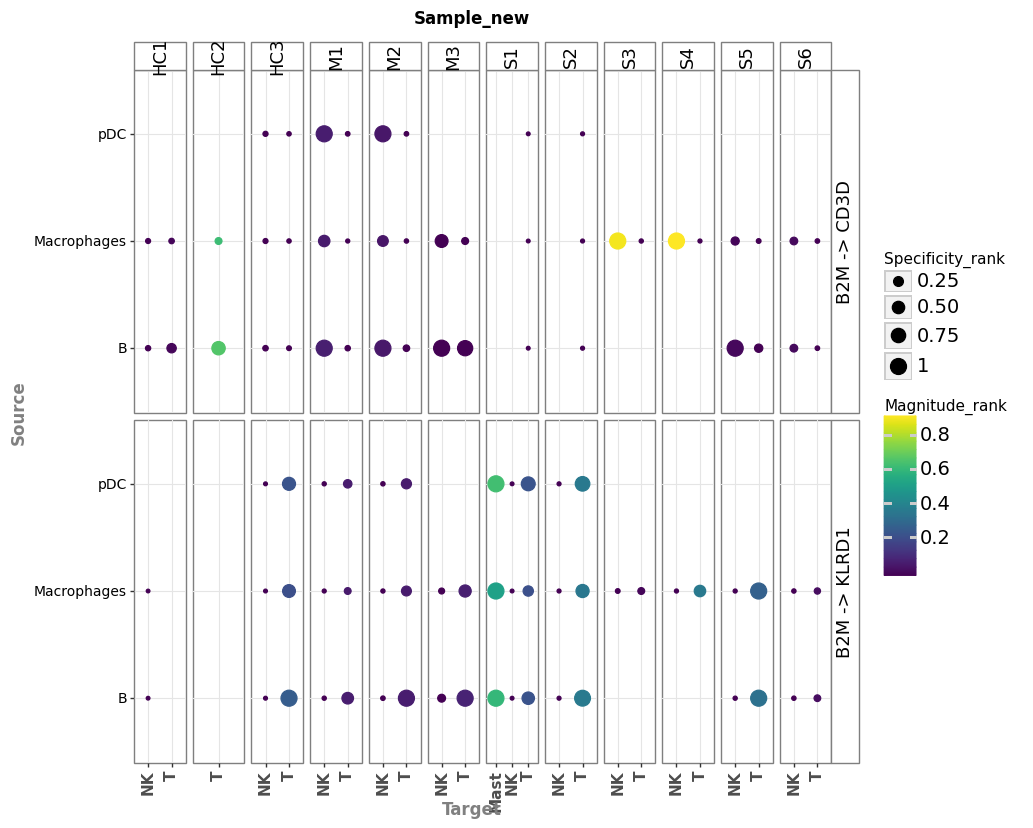

<ggplot: (8794851263359)>

In [69]:
li.pl.dotplot_by_sample(adata=adata,
                        colour='magnitude_rank',
                        size='specificity_rank',
                        source_labels=["B", "pDC", "Macrophages"],
                        target_labels=["T", "Mast", "pDC", "NK"],
                        ligand_complex = 'B2M',
                        receptor_complex= ['CD3D', 'KLRD1'],
                        sample_key='sample_new',
                        figure_size=(9, 9),
                        size_range=(1, 6),
                        )

Here, we can already see that the ligand-receptor interactions are not only specific to cell types, but also to samples or contexts (see **B2M -> KLRD1** in samples *M1*, *M2*, *M3*). However, we can also see that this plot even with two interactions starts to get a bit overwhelming. To this end, to make the most use of the hypothesis-free nature of the ligand-receptor interactions, in the next chapter we will use `Tensor-Cell2cell` to decompose the ligand-receptor interactions into interpretable CCC patterns across contexts.

Save Results for Tensor-Cell2cell

In [56]:
adata.uns['liana_res'].to_csv(output_folder + 'LIANA_by_sample.csv', index=False)

Next Chapter: 03-Generate-Tensor.

## Supplementary Information about LIANA

### Independent Methods

Although, in these tutorials we will use the consensus score, one can also run the different methods independently via LIANA.

In [22]:
from liana.method import cellphonedb, cellchat, geometric_mean, singlecellsignalr, natmi, connectome, logfc

Each of these is an instance of Class Method in LIANA and comes with it's own metadata. For example, let's examine the metadata of the CellPhoneDBv2 method:

In [23]:
cellphonedb.describe()

CellPhoneDB uses `lr_means` and `cellphone_pvals` as measures of expression strength and interaction specificity, respectively


We can also check in what order show one interpret the results from each method:

In [29]:
{ cellphonedb.magnitude : cellphonedb.magnitude_ascending }

{'lr_means': False}

In [30]:
{ cellphonedb.specificity : cellphonedb.specificity_ascending }

{'cellphone_pvals': True}

Similarly, we can obtain the reference for the method:

In [31]:
cellphonedb.reference

'Efremova, M., Vento-Tormo, M., Teichmann, S.A. and Vento-Tormo, R., 2020. CellPhoneDB: inferring cell–cell communication from combined expression of multi-subunit ligand–receptor complexes. Nature protocols, 15(4), pp.1484-1506. '

### Key Parameters

We already covered some of the parameters in LIANA, that can be used to customize the results. Here, we will go in more detail over some of the most important ones.


- `resource` and `resource_name` enable the user to select the resource that they want to use for CCC inference. By default, liana will use the 'consensus' resource which combines a number of expert-curated ligand-receptor resources. However, one can also use the 'cellphonedb' resource, any of the resources that are available within liana by passing their `resource_name` (See below). Additionally, the user can pass their own resource via the `resource` parameter, which expects a pandas DataFrame.


In [46]:
li.resource.show_resources()

['baccin2019',
 'cellcall',
 'cellchatdb',
 'cellinker',
 'cellphonedb',
 'celltalkdb',
 'connectomedb2020',
 'consensus',
 'embrace',
 'guide2pharma',
 'hpmr',
 'icellnet',
 'italk',
 'kirouac2010',
 'lrdb',
 'mouseconsensus',
 'ramilowski2015']


- `expr_prop` which we also used before is the proportion of cells that need to express a ligand-receptor pair for it to be considered as a potential ligand-receptor pair. This is a parameter that can be used to filter out lowly-expressed ligand-receptor pairs. This is common practice in CCC inference at the cluster level, as we make the assumption that the event occurs for all cells within that clusters.

- `return_all_lrs` is related to the `expr_prop` parameter. If `return_all_lrs` is set to `True`, then all ligand-receptor pairs will be returned, regardless of whether they are expressed above the `expr_prop` threshold. This is useful if one wants to use the `expr_prop` parameter to filter out lowly-expressed ligand-receptor pairs, but still wants to see the scores for all ligand-receptor pairs.

- `supp_columns` is a list of columns that can be added to the `adata.uns['liana_res']` dataframe. These are typically other stats that are calculated for each ligand and receptor, such as the 1vsRest differential expression p-value, or any other stat from another method.

In addition to those parameters liana provides a number of other utility parameters as well as some method-specific ones, please refer to the documentation for more information.

In [44]:
?cellphonedb

Signature:     
cellphonedb(
    adata: 'AnnData',
    groupby: 'str',
    resource_name: 'str' = 'consensus',
    expr_prop: 'float' = 0.1,
    min_cells: 'int' = 5,
    base: 'float' = 2.718281828459045,
    supp_columns: 'list' = None,
    return_all_lrs: 'bool' = False,
    use_raw: 'Optional[bool]' = True,
    layer: 'Optional[str]' = None,
    de_method='t-test',
    verbose: 'Optional[bool]' = False,
    n_perms: 'int' = 1000,
    seed: 'int' = 1337,
    resource: 'Optional[DataFrame]' = None,
    inplace=True,
)
Type:           Method
String form:    <liana.method._Method.Method object at 0x7ffb736a83a0>
File:           ~/anaconda3/envs/cell2cell/lib/python3.8/site-packages/liana/method/_Method.py
Docstring:      liana's Method Class
Init docstring:
Parameters
----------
method_name
    Name of the Method
complex_cols
    Columns relevant for protein complexes
add_cols
    Additional columns required by the method
fun
    Interaction Scoring function
magnitude
    Name of the `